Image array shape: (96, 84, 27)
Number of pixel inside mask): 8064


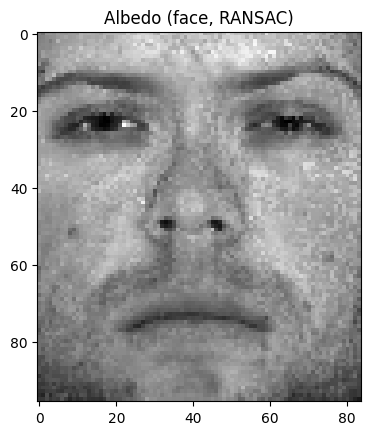

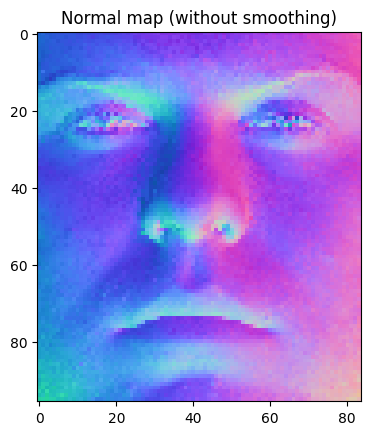

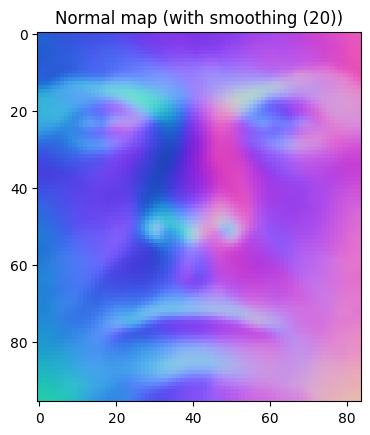

albedo mapping is not implemented yet...


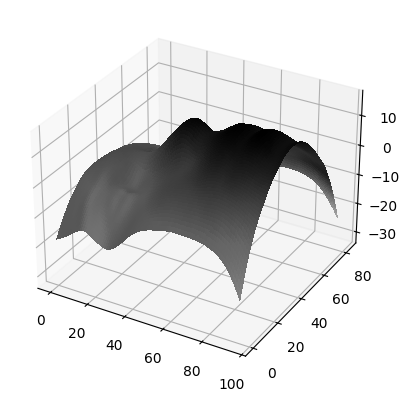

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from ps_utils import (
    read_data_file,
    ransac_3dvector,
    smooth_normal_field,
    unbiased_integrate,
    display_surface,
)

#load data (face dataset)
I, mask, S = read_data_file("face.mat")  
m, n, k = I.shape
print("Image array shape:", I.shape) 
assert k == 27

#select valid pixels using the mask
mask_bool = (mask > 0)
nz = np.count_nonzero(mask_bool)
print("Number of pixel inside mask):", nz)

#Build the data matrix J (27, nz)
J = np.zeros((k, nz), dtype=float)
for i in range(k):
    img = I[:, :, i]
    J[i, :] = img[mask_bool]  

#Estimate m = rho * n for each pixel using RANSAC
M = np.zeros((3, nz), dtype=float)
threshold = 10.0

for j in range(nz):
    I_vec = J[:, j]
    data = (I_vec, S)      

    result = ransac_3dvector(data, threshold=threshold, verbose=0)

    if result is None:
        m_hat = np.linalg.lstsq(S, I_vec, rcond=None)[0]
    else:
        m_hat, inliers, best_fit = result

    M[:, j] = m_hat

#compute albedo and normals from m
rho = np.linalg.norm(M, axis=0) 
eps = 1e-8 #avoiding division by zero
rho_safe = np.maximum(rho, eps)     

n_vec = M / rho_safe
n1 = n_vec[0, :]
n2 = n_vec[1, :]
n3 = n_vec[2, :]

#map albedo and normals back to image shape (m, n)
albedo_img = np.zeros((m, n), dtype=float)
n1_img     = np.zeros((m, n), dtype=float)
n2_img     = np.zeros((m, n), dtype=float)
n3_img     = np.zeros((m, n), dtype=float)

albedo_img[mask_bool] = rho
n1_img[mask_bool]     = n1
n2_img[mask_bool]     = n2
n3_img[mask_bool]     = n3

#smooth the normal field
n1_s, n2_s, n3_s = smooth_normal_field(
    n1_img, n2_img, n3_img,
    mask=mask,
    iters= 20,
    tau=0.05,
    verbose=False,
)

#integrate normals to obtain depth
z_unsmoothed = unbiased_integrate(n1_img,  n2_img,  n3_img,  mask)
z_smoothed   = unbiased_integrate(n1_s, n2_s, n3_s, mask)

#results

#albedo
plt.figure()
plt.title("Albedo (face, RANSAC)")
plt.imshow(albedo_img, cmap="gray")


#normal map without smoothing 
normal_rgb = np.zeros((m, n, 3), dtype=float)
normal_rgb[:, :, 0] = (n1_img + 1) / 2
normal_rgb[:, :, 1] = (n2_img + 1) / 2
normal_rgb[:, :, 2] = (n3_img + 1) / 2

plt.figure()
plt.title("Normal map (without smoothing)")
plt.imshow(normal_rgb)


#normal map with smoothing
normal_rgb_s = np.zeros((m, n, 3), dtype=float)
normal_rgb_s[:, :, 0] = (n1_s + 1) / 2
normal_rgb_s[:, :, 1] = (n2_s + 1) / 2
normal_rgb_s[:, :, 2] = (n3_s + 1) / 2

plt.figure()
plt.title("Normal map (with smoothing (20))")
plt.imshow(normal_rgb_s)


plt.show()

#3D surface
display_surface(z_smoothed, albedo=albedo_img)

